In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

import tensorflow as tf


assert tf.__version__[0] == '2' , "Update tf version"


print("Tf version = " + str(tf.__version__) + " | Keras version = " + str(tf.keras.__version__))

assert len(tf.config.list_physical_devices('GPU')) > 0 , "Try to use at least on GPU for this task"

Tf version = 2.4.1 | Keras version = 2.4.0


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, axis = -1) / 255
x_test  = np.expand_dims(x_test, axis = -1) / 255

initial_shape = x_train[0].shape

## Building an efficient preprocessing pipeline

In [ ]:
batch_size = 64
train_data = tf.data.Dataset.from_tensor_slices((x_train,x_train))
train_data = train_data.map(lambda x,y : (tf.cast(x,tf.float32),tf.cast(y,tf.float32)) )
train_data = train_data.shuffle(x_train.shape[0]).batch(batch_size).prefetch(1)

test_data = tf.data.Dataset.from_tensor_slices((x_test,x_test))
test_data = test_data.map(lambda x,y : (tf.cast(x,tf.float32),tf.cast(y,tf.float32)))
test_data = test_data.shuffle(x_test.shape[0]).batch(batch_size).prefetch(1)

## Deep AutoEncoder

In [ ]:
from functools import partial

ConvolutionalLayer = partial(
                        tf.keras.layers.Conv2D,
                        filters = 64,
                        kernel_size = 3,
                        padding = 'valid',
                        strides = 1,
                        activation = 'relu',
                        #kernel_initializer = tf.keras.initializers.HeNormal()
)

TransposedConvolutional = partial(
                        tf.keras.layers.Conv2DTranspose,
                        filters = 64,
                        kernel_size = 1,
                        padding = 'valid',
                        strides = 1,
                        activation = 'relu',
                        #kernel_initializer = tf.keras.initializers.HeNormal()
)

In [ ]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28,28,1)),
    tf.keras.layers.GaussianNoise(stddev=0.1),
    ConvolutionalLayer(filters = 64 , kernel_size = 3, strides = 2),
    ConvolutionalLayer(filters = 128, kernel_size = 3),
    ConvolutionalLayer(filters = 128, kernel_size = 3, name = 'codings')
])

encoder._name = 'encoder'


decoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=encoder.output_shape[1:]),
    TransposedConvolutional(filters = 128 , kernel_size = 3, strides = 1),
    TransposedConvolutional(filters = 64, kernel_size = 3, strides = 1),
    #reconstruct loss
    TransposedConvolutional(filters = 1, kernel_size = 4, strides = 2, name = 'reconstructed_image'),
])

decoder._name = 'decoder'

#encoder.summary()
#decoder.summary()

autoencoder = tf.keras.Sequential([
    tf.keras.Input(shape=initial_shape),
    encoder,
    decoder
])

autoencoder.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 9, 9, 128)         222080    
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         222401    
Total params: 444,481
Trainable params: 444,481
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy'
)

lr_shceduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=10,mode='min',min_lr=1e-5)

autoencoder.fit(
    train_data,
    epochs = 20,
    validation_data = test_data,
    callbacks = [lr_shceduler],
    verbose = 1
)

Epoch 1/20
938/938 [==============================] - 9s 7ms/step - loss: 0.1436 - val_loss: 0.0823
Epoch 2/20
938/938 [==============================] - 8s 7ms/step - loss: 0.0942 - val_loss: 0.0772
Epoch 3/20
938/938 [==============================] - 8s 7ms/step - loss: 0.1201 - val_loss: 0.1020
Epoch 4/20
938/938 [==============================] - 8s 7ms/step - loss: 0.0915 - val_loss: 0.0787
Epoch 5/20
938/938 [==============================] - 8s 7ms/step - loss: 0.0969 - val_loss: 0.0904
Epoch 6/20
938/938 [==============================] - 8s 7ms/step - loss: 0.0837 - val_loss: 0.0778
Epoch 7/20
938/938 [==============================] - 8s 7ms/step - loss: 0.0972 - val_loss: 0.0774
Epoch 8/20
938/938 [==============================] - 8s 7ms/step - loss: 0.0810 - val_loss: 0.0744
Epoch 9/20
938/938 [==============================] - 8s 7ms/step - loss: 0.0838 - val_loss: 0.0817
Epoch 10/20
938/938 [==============================] - 8s 7ms/step - loss: 0.0835 - val_loss: 0.1521

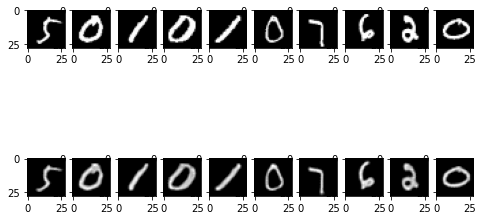

In [ ]:
plt.figure(figsize=(8,5))

for x_batch, y_batch in test_data.take(1):
  for i in range(10):
    
    true_image = x_batch[i].numpy()
    generated_image = autoencoder.predict(true_image[np.newaxis])
    
    plt.subplot(2,10,i+1)
    plt.imshow(true_image.reshape(28,28),cmap='gray')
    plt.subplot(2,10,i+1+10)
    plt.imshow(generated_image.reshape(28,28),cmap='gray')

## Variational Auto-Encoder

> The VAE loss is constituted by two parts.
  1. The reconstruction loss, provided by the difference between the true images and the reconstructed ones.
  2. The latent loss, the difference between the probability distribuition of the VAE latent space and a specific distribuition(in this case a  gaussian).

In the latent loss, I'm using a trick. Instead of returning the var from the encoder, I instead use it as the log_var to reduce the complexity. Check latent loss VAE for further explanation [VAE Latent loss](https://stats.stackexchange.com/questions/304289/variational-autoencoder-understanding-the-latent-loss)


> **Use a ore complex architecture**

In [ ]:
#We use a sampling class instead of returning a gaussian with the latent mean and log_var because of the derivatives.
#Basically the derivatives would have been block if one don't use a custon gaussian and then transformed it into the right mean and variance.
class Sampling(tf.keras.layers.Layer):
  #def __init__(self,mean = ):
  def call(self,inputs):
    mean,log_var = inputs
    return tf.random_normal_initializer(mean=0,stddev=1,seed=42)(shape=tf.shape(mean)) * tf.math.exp(log_var / 2) + mean 



In [ ]:
coding_size = 14

inputs_en = tf.keras.layers.Input(shape=(28,28,1),name='image')
x = tf.keras.layers.GaussianNoise(stddev=0.1)(x)
x = ConvolutionalLayer(filters = 64 , kernel_size = 6, strides = 1)(inputs_en)
x = tf.keras.layers.MaxPooling2D()(x)
x = ConvolutionalLayer(filters = 128, kernel_size = 3)(x)
x = ConvolutionalLayer(filters = 128, kernel_size = 3)(x)
x = tf.keras.layers.Flatten()(x)

mean = tf.keras.layers.Dense(coding_size,name='mean')(x)
log_var = tf.keras.layers.Dense(coding_size,name='log_var')(x)
coding_samples = Sampling()([mean,log_var])

encoder = tf.keras.models.Model(inputs = inputs_en, outputs = [mean,log_var,coding_samples])

#encoder.summary()

inputs_dec = tf.keras.layers.Input(shape=(coding_size,),name='latent_space')
x = tf.keras.layers.Dense(units = 6272)(inputs_dec)
x = tf.keras.layers.Reshape([7,7,128])(x)
x = TransposedConvolutional(filters = 128 , kernel_size = 3, strides = 1)(x)
x = TransposedConvolutional(filters = 64, kernel_size = 3, strides = 1)(x)
x = TransposedConvolutional(filters = 64, kernel_size = 3, strides = 2)(x)

out = TransposedConvolutional(filters = 1, kernel_size = 6, strides = 1, name = 'reconstructed_image')(x)
#reconstructed image


decoder = tf.keras.models.Model(inputs = inputs_dec, outputs = out)

#encoder.summary()
#decoder.summary()


mean,log_var,codings = encoder(inputs_en)
reconstructed_images = decoder(codings)
variational_ae = tf.keras.models.Model(inputs=inputs_en,outputs=reconstructed_images)

variational_ae.summary()

latent_loss = -0.5 * tf.math.reduce_sum( 1 +  log_var - tf.math.exp(log_var/2) - tf.square(mean) , axis = -1)
variational_ae.add_loss(tf.math.reduce_mean(latent_loss)/(28*28))




Model: "model_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_71 (Functional)        [(None, 14), (None, 14),  399452    
_________________________________________________________________
model_72 (Functional)        (None, 28, 28, 1)         354689    
Total params: 754,141
Trainable params: 754,141
Non-trainable params: 0
_________________________________________________________________


In [ ]:
variational_ae.compile(
    optimizer = 'rmsprop',
    loss = 'binary_crossentropy'
)

lr_shceduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5,mode='min',min_lr=1e-5)

history = variational_ae.fit(
    train_data,
    epochs = 30,
    validation_data = test_data,
    callbacks = [lr_shceduler],
    verbose = 1
)

Epoch 1/30
938/938 [==============================] - 11s 9ms/step - loss: 0.2916 - val_loss: 0.1957
Epoch 2/30
938/938 [==============================] - 9s 8ms/step - loss: 0.2086 - val_loss: 0.2502
Epoch 3/30
938/938 [==============================] - 9s 9ms/step - loss: 0.2355 - val_loss: 0.2038
Epoch 4/30
938/938 [==============================] - 9s 9ms/step - loss: 0.2352 - val_loss: 0.1978
Epoch 5/30
938/938 [==============================] - 9s 9ms/step - loss: 0.1980 - val_loss: 0.1827
Epoch 6/30
938/938 [==============================] - 9s 9ms/step - loss: 0.1971 - val_loss: 0.2605
Epoch 7/30
938/938 [==============================] - 9s 9ms/step - loss: 0.2379 - val_loss: 0.1948
Epoch 8/30
938/938 [==============================] - 9s 9ms/step - loss: 0.2302 - val_loss: 0.2049
Epoch 9/30
938/938 [==============================] - 9s 8ms/step - loss: 0.1990 - val_loss: 0.1847
Epoch 10/30
938/938 [==============================] - 9s 8ms/step - loss: 0.1948 - val_loss: 0.202

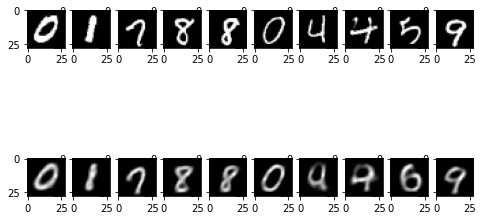

In [ ]:
plt.figure(figsize=(8,5))

for x_batch, y_batch in test_data.take(1):
  for i in range(10):
    
    true_image = x_batch[i].numpy()
    generated_image = variational_ae.predict(true_image[np.newaxis])
    
    plt.subplot(2,10,i+1)
    plt.imshow(true_image.reshape(28,28),cmap='gray')
    plt.subplot(2,10,i+1+10)
    plt.imshow(generated_image.reshape(28,28),cmap='gray')

### Now let's progress to gans

In [ ]:
random_input_dimension = (10,10,1)
input_shape = (28,28,1)
#inputs = tf.keras.random_normal_initializer(mean=0,stddev=1)(shape=(random_input_dimension))

generator = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(random_input_dimension)),
  TransposedConvolutional(filters = 128, kernel_size = 3, strides = 2),
  TransposedConvolutional(filters = 128, kernel_size = 3, strides = 1),
  TransposedConvolutional(filters = 64, kernel_size = 3, strides = 1),
  TransposedConvolutional(filters = 1 , kernel_size = 4, strides = 1),
])

#generator.summary()


#inputs = tf.keras.random_normal_initializer(mean=0,stddev=1)(shape=(random_input_dimension))
discriminator = tf.keras.models.Sequential([
  #tf.keras.layers.Input(shape=(input_shape)),
  ConvolutionalLayer(filters = 64 , kernel_size = 3),
  tf.keras.layers.MaxPooling2D(),
  ConvolutionalLayer(filters = 128, kernel_size = 3),
  ConvolutionalLayer(filters = 128, kernel_size = 3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units = 128, activation = 'relu'),
  tf.keras.layers.Dense(units = 1, activation = 'sigmoid')
])


#decoder.summary()

gan = tf.keras.models.Sequential([generator,discriminator])
discriminator.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics=['acc'])
discriminator.trainable = False
gan.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics=['acc'])

In [ ]:
discriminator.summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_208 (Conv2D)          (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_209 (Conv2D)          (None, 11, 11, 128)       73856     
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 9, 9, 128)         147584    
_________________________________________________________________
flatten_65 (Flatten)         (None, 10368)             0         
_________________________________________________________________
dense_50 (Dense)             (None, 128)               1327232   
_________________________________________________________________
dense_51 (Dense)             (None, 1)               

In [ ]:
def train_gan(gan, train_dataset, batch_size, n_epochs):
  generator, discriminator = gan.layers
  
  for epoch in range(n_epochs):
    
    discriminator_batch_loss = 0
    discriminator_batch_acc = 0
    gan_batch_loss = 0
    gan_batch_acc = 0

    for step,(X_batch,y_batch) in enumerate(train_dataset.take(100)):
    
      noise = tf.random_normal_initializer(mean=0,stddev=1)(shape=(batch_size,10,10,1))
      images = generator(noise)

      #------#-----#-----#
      #Fase 1 - Generate images with the generator and train the decoder
      #------#-----#-----#

      #(batch,28,28,1)
      X_fake_and_real = tf.concat([images,X_batch],axis=0)
      Y_fake_and_real = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
     
      X_fake_and_real = tf.random.shuffle(X_fake_and_real, seed = 42)
      Y_fake_and_real = tf.random.shuffle(Y_fake_and_real, seed = 42)

      discriminator.trainable = True
      #print(X_fake_and_real.shape)
      #print(Y_fake_and_real.shape)
      
      metrics = discriminator.train_on_batch(X_fake_and_real,Y_fake_and_real)
      discriminator_batch_loss += metrics[0]
      discriminator_batch_acc += metrics[1]
      
      

      #------#-----#-----#
      #Fase 2 - Train the generator 
      #------#-----#-----#

      noise = tf.random_normal_initializer(mean=0,stddev=1)(shape=(batch_size,10,10,1))
      y2 = tf.constant([[1.]]*batch_size)

      discriminator.trainable = False
      metrics = gan.train_on_batch(noise,y2)
      gan_batch_loss += metrics[0]
      gan_batch_acc += metrics[1]
      
    
    print("Gan loss = {0} | Gan accuracy = {1} | Discriminator accuracy = {2} | Discriminator loss = {3}".format( gan_batch_loss/step , gan_batch_acc/step , discriminator_batch_acc/step , discriminator_batch_loss/step))

train_gan(gan, train_data, batch_size, 10)


Gan loss = 0.7001486691561613 | Gan accuracy = 0.0 | Discriminator accuracy = 0.5050505050505051 | Discriminator loss = 0.7001486691561613
Gan loss = 0.7001486691561613 | Gan accuracy = 0.0 | Discriminator accuracy = 0.5050505050505051 | Discriminator loss = 0.7001486691561613
Gan loss = 0.7001486691561613 | Gan accuracy = 0.0 | Discriminator accuracy = 0.5050505050505051 | Discriminator loss = 0.7001486691561613
Gan loss = 0.7001486691561613 | Gan accuracy = 0.0 | Discriminator accuracy = 0.5050505050505051 | Discriminator loss = 0.7001486691561613
Gan loss = 0.7001486691561613 | Gan accuracy = 0.0 | Discriminator accuracy = 0.5050505050505051 | Discriminator loss = 0.7001486691561613
Gan loss = 0.7001486691561613 | Gan accuracy = 0.0 | Discriminator accuracy = 0.5050505050505051 | Discriminator loss = 0.7001486691561613
Gan loss = 0.7001486872181748 | Gan accuracy = 0.0 | Discriminator accuracy = 0.5050505050505051 | Discriminator loss = 0.7001486691561613
Gan loss = 0.70014866915616

In [ ]:
gan.test_on_batch?